# Analysis of Groove Widths in Periodic DNA

Now I'll use pyña to analyze the major and minor groove widths from Eva's results for the periodic DNA.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pyna
periodic = pyna.CurvesAnalysis('../curves_output.data')

In [2]:
minor = periodic.panels['groupE']['w12']
major = periodic.panels['groupE']['w21']

In [3]:
w12_by_location = [pyna.StrandStatistics(minor, locations=loc) for loc in minor.columns]
w21_by_location = [pyna.StrandStatistics(major, locations=loc) for loc in major.columns]
# TODO: StrandStatistics needs a default label to use

In [4]:
# TODO: all of these should be simplified by wrapping the above into some object
minor_means = [loc.mean() for loc in w12_by_location]
minor_stds = [loc.std() for loc in w12_by_location]
major_means = [loc.mean() for loc in w21_by_location]
major_stds = [loc.std() for loc in w21_by_location]

xvals = minor.columns.values

(0, 16.0)

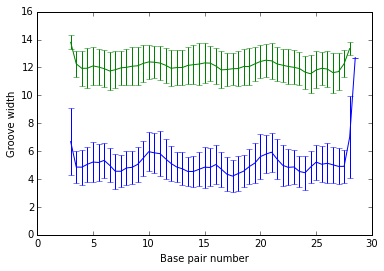

In [5]:
plt.figure()
plt.errorbar(xvals, minor_means, yerr=minor_stds)
plt.errorbar(xvals, major_means, yerr=major_stds)
plt.xlabel("Base pair number")
plt.ylabel("Groove width")
plt.gca().set_ylim(ymin=0); # force the yaxis to go to 0

In [6]:
# parts stolen from: http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/

import matplotlib.animation as anim
import numpy as np

from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")
    
    return VIDEO_TAG.format(anim._encoded_video)


from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))


class AnimatedDataFrame(object):
    def __init__(self, df, columns=None):
        self.df = df
        if columns != None:
            self.xvals = columns
        else:
            self.xvals = df.columns.values
        self.fig, self.ax = plt.subplots()
        self.line, = self.ax.plot(xvals, self.df.loc[0,:])
        init = lambda : self.init()
        animate = lambda i : self.animate(i)
        self.ani = anim.FuncAnimation(self.fig, animate, self.df.index.values, init_func=init, interval=25, blit=True)

        
    def animate(self, i):
        self.line.set_ydata(self.df.loc[i,:])
        return self.line,
        
    def init(self):
        self.line.set_ydata(np.ma.array(self.xvals, mask=True))
        return self.line,
    
    def show(self):
        return display_animation(self.ani)


In [7]:
AnimatedDataFrame(minor).show()

In [8]:
# TODO: replace these hists with my histogram object
hists = [loc.hist(bins=28, range=(0.0,14.0)) for loc in w12_by_location]

In [9]:
# get bins:
for hist in hists:
    if len(hist[1]) > 0:
        bins = hist[1]
        break
#print bins
hist_dict = {}
for i in range(len(hists)):
    if len(hists[i][0]) == 0:
        myhist = [0]*(len(bins)-1)
    else:
        myhist = hists[i][0]
    hist_dict[minor.columns.values[i]] = myhist

In [10]:
import pandas as pd
hist_df = pd.DataFrame(hist_dict).set_index(bins[:-1])

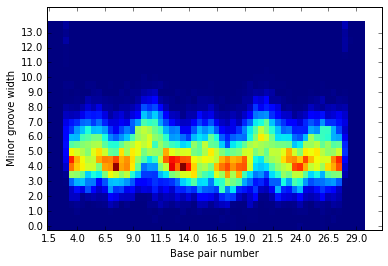

In [11]:
plt.pcolor(hist_df)
plt.yticks(np.arange(0.5, len(hist_df.index), 2), hist_df.index[::2])
plt.xticks(np.arange(0.5, len(hist_df.columns), 5), hist_df.columns[::5])
plt.xlabel("Base pair number")
plt.ylabel("Minor groove width")
plt.show()
#TODO: recheck that the tick marks are really correct here